## Supervised Learning
## Project: Finding Donors for *CharityML*

In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=10))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
income_categories = data.groupby(['income']).income.count()
n_greater_50k = income_categories['>50K']

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = income_categories['<=50K']

# TODO: Percentage of individuals whose income is more than $50,000
percent_categorization = data['income'].value_counts(normalize=True) * 100
greater_percent = percent_categorization['>50K']

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

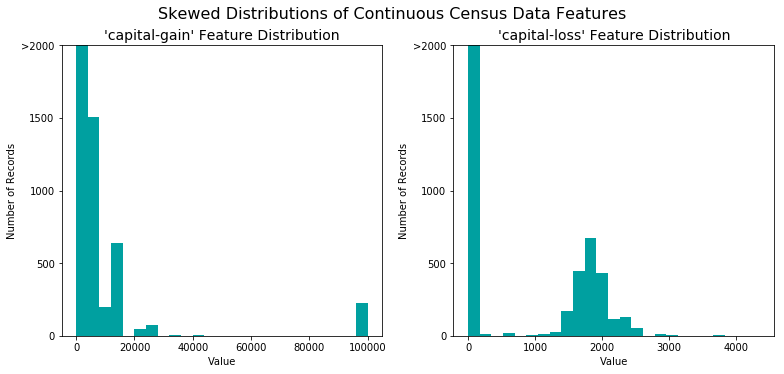

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

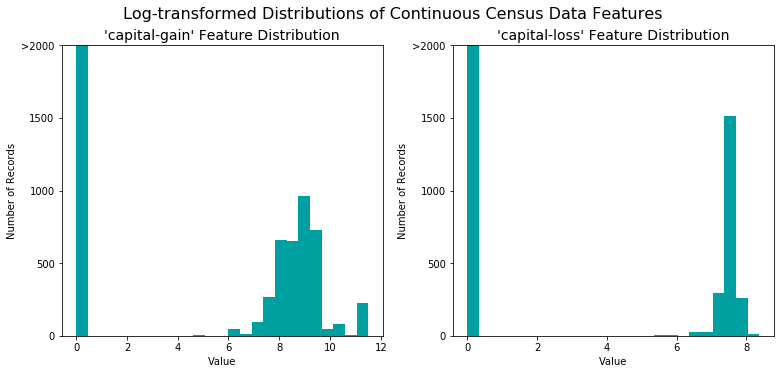

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K':0,'>50K':1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [8]:

TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
# encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy = TP/(FP + TP)
recall = TP/(TP+FN)
precision = TP/(FP + TP)
# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1+0.5**2)*((precision*recall)/((0.5**2*precision)+recall))
# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

**Answer:**

The list of all the three supervised learning Models that are appropriate to this Problem and we will test them on census data are :-

**1. Ensemble Methods- Random Forest**

**One real world application in industry where the model can be applied :-**

Recommendation Engine in E-Commerce . It can be used in E-Commerce to Predict Whether the customer will actually buy the product or not . Or what product is the customer more likely to buy . 

**The strengths of the model and scenarios when it will perform good :-**

1. The very common Problem In Machine Learning is Overfitting and this won't happen easily to a Random Forest Classifier . Thus Random Forest Classifier don't tend to overfit easily . 

2. Random Forest requires no input data preparation . They can deal with both numerical data and categorial data . 

3. Random forest usually do well with default hyperparameters and does not require lot of tweaking in the default parameters to perform good . 

4. Random Forest Run times are pretty Fast . It is fast to train . Individual decision trees can be trained parallely . 

5. The random forest algorithm can also be used for feature engineering . That is it can be used to identify the most important features . 

6. Higher Accuracy - Random Forest can make wrong prediction only when half or more than half of the classifiers are incorrect . 

**Some weaknesses of the model and scenarios when it will perform bad :-**

1. A large number of predictions can make the algorithm slow during predictions . Hence we cannot make real time predictions in Random Forest . 

2. Random Forest Is A black box model and hence it can't help humans understand the factors on the basis of which these predictions are made . Hence they are not human interpretable . 

3. It is more complex and also computationally expensive . 

**What makes random forest a good candidate for the problem, given what you know about the data :-**

1. Random Forest Algorithm can deal with both categorial and numerical data . As we can see in our problem set of 'Finding donors to charity ML', there are features like - age, education-num, capital-gain, capital-loss, hours-per-week which are continuous and others like workclass, education, marital-status, occupation, relationship, race, sex, native-country which are categorial . So as our dataset comprise of both Numerical and Categorial Datasets . Also with this we are clear that since the model has the capability to deal with both numerial and categorial data . 

2. As Random Forest Algorithm don't Overfit , it is in our favour to use such a algorithm for our usecase because accuracy is our primary concern as it is made clear in the Project Description stated under 'Software Requirement Section' quoted with lines " Your goal will be evaluate and optimize several different supervised learners to determine which algorithm will provide the highest donation yield while also reducing the total number of letters being sent" . So if our model don't overfit easily it is likely to perform better and yield higher accuracy . 

3. As Random Forest can also be used for feature engineering it will be easier for us to understand which features were contributing to the predictions made later . 

4. Also random forest do well with default hyperparamters so no tweaking of models required from our side . 




**References for  random Forest :** 
http://dataaspirant.com/2017/05/22/random-forest-algorithm-machine-learing/
https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd
https://medium.com/rants-on-machine-learning/the-unreasonable-effectiveness-of-random-forests-f33c3ce28883
https://blog.easysol.net/machine-learning-algorithms-2/
https://medium.com/datadriveninvestor/introduction-to-random-forest-algorithm-with-python-9efd1d8f0157
https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/



**2. Support Vector Machines**

**One real world application in industry where the model can be applied :-**

Support Vector Machines can be used for handwriting recognisation . 

**The strengths of the model and scenarios when it will perform good :-**
1. Support Vector Machines are effective , when the number of features are quite large than the number of samples .  

2. It performs good on cleaner datasets and hence gives better accuracy there . 

3. It is effective in high dimensions space . 

4. Since only a subset of training points are used in the decision function (called support vectors), it is quite memory efficient. This also leads to extremely fast prediction.


**Some weaknesses of the model and scenarios when it will perform bad :-**

1. It does not perform well when dataset has noise . 

2. Support Vector Machines have high algorithmic complexity and extensive memory requirements due to the use of quadratic programming.

3. Another limitation of Support Vector Machine is the choice of the kernel. If we make a  wrong choice of the kernel can lead to an increase in error percentage .

4. It is a black box algorithm as it is not human interpretable . The complex data transformations and resulting boundary plane are very difficult to interpret. 

5. SVM doesn’t directly provide probability estimates, these are calculated using an expensive five-fold cross-validation. It is related SVC method of Python scikit-learn library.(Since we are using scikit learn it is worth mentioning this here . )

**What makes Support Vector Machine a good candidate for the problem, given what you know about the data :-**

1. As quoted in the getting started section of this project - "The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries." As we know that we don't have missing data in our dataset or ill formatted data , this is an advantage for us to use support vector machines in this scenario because support vector machines perform good on cleaner dataset and hence gives better accuracy there .

2. As we know that we have more than one feature in our dataset , we have high dimensional dataset and it is usually preferred to use support vector machine in case of high dimensional dataset . 



**References for  Support Vector Machine :**

https://data-flair.training/blogs/applications-of-svm/
https://www.kdnuggets.com/2016/07/support-vector-machines-simple-explanation.html
https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
https://sadanand-singh.github.io/posts/svmpython/
http://dataaspirant.com/2017/01/13/support-vector-machine-algorithm/
https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

**3. Decision Trees**

**One real world application in industry where the model can be applied :-**
Predicting Future Trends in stock market using decision trees . 

**The strengths of the model and scenarios when it will perform good :-**
1. It is interpretable as it mimics human thinking style . 

2. You can see the logic so it is not a black box kind of model . 

3. Decision trees implicitly perform variable screening or feature selection.

4. Decision trees require relatively little effort from users for data preparation.It deals with missing values by filling the most appropriate values . 

5. Decision trees is suitable for handling both categorical and quantitative values

**Some weaknesses of the model and scenarios when it will perform bad :-**
1. It tends to overfits on the training data and thus end up memorizing the training data and hence perform poorly on the testing data . 

2. In some cases decision trees turn out to be very complex . 

3. Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the data set prior to fitting with the decision tree.

**What makes Decision Trees  a good candidate for the problem, given what you know about the data :-**

1. Decision Tree Algorithm can deal with both categorial and numerical data . As we can see in our problem set of 'Finding donors to charity ML', there are features like - age, education-num, capital-gain, capital-loss, hours-per-week which are continuous and others like workclass, education, marital-status, occupation, relationship, race, sex, native-country which are categorial . So as our dataset comprise of both Numerical and Categorial Datasets . Also with this we are clear that since the model has the capability to deal with both numerial and categorial data . 

2. As Decision Tree can also be used for feature engineering it will be easier for us to understand which features were contributing to the predictions made later . 

3. Again as quoted in the getting started section "This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources . "

The above quote helps us understand that our model will be benefical for non profit setting organisations, who are trying to understand an individual's income based on which they will plan a cold call or more likely will shoot them an email to donate and not just that but also how much of donation to expect will also depend on our model . There executives who are making a decision to shoot these emails , it is equally important for them to understand how our model made that prediction and based on what factor it made that prediction . Since Decision tree is not a black box model , it is quite possible for us to explain the factors on the basis of which we made the decision . Thus the model is human interpretable . 

The added advantage of a model being human interpretable is not just making the executive of the company understand the criteria but also tweak the results as per human intelligence . Like suppose a feature which was pretty relevant in 1948 when our model was made but hold no relevance as of today and our decision in the prediction is affected by that the person or the executive making the final decision for the company can keep that in mind while making the decision and this can happen only if the model is explainable to humans . 



**References for  Decision Trees :**

https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052
https://www.analyticsvidhya.com/blog/2015/01/decision-tree-simplified/2/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4466856/
https://medium.com/deep-math-machine-learning-ai/chapter-4-decision-trees-algorithms-b93975f7a1f1


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time

    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start 
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, 0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
    print(results['f_test'])
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [10]:
### Implementation: Initial Model Evaluation
##In the code cell, you will need to implement the following:
#- Import the three supervised learning models you've discussed in the previous section.
#- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  #- Use a `'random_state'` for each model you use, if provided.
  #- **Note:** Use the default settings for each model — you will tune one specific model in a later section.
#- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  #- Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

#**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

0.603512905644
RandomForestClassifier trained on 361 samples.
0.664742973175
RandomForestClassifier trained on 3617 samples.
0.684178683069
RandomForestClassifier trained on 36177 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0
SVC trained on 361 samples.
0.671256454389
SVC trained on 3617 samples.
0.6744771707
SVC trained on 36177 samples.
0.509522631709
DecisionTreeClassifier trained on 361 samples.
0.596478934922
DecisionTreeClassifier trained on 3617 samples.
0.628634727222
DecisionTreeClassifier trained on 36177 samples.


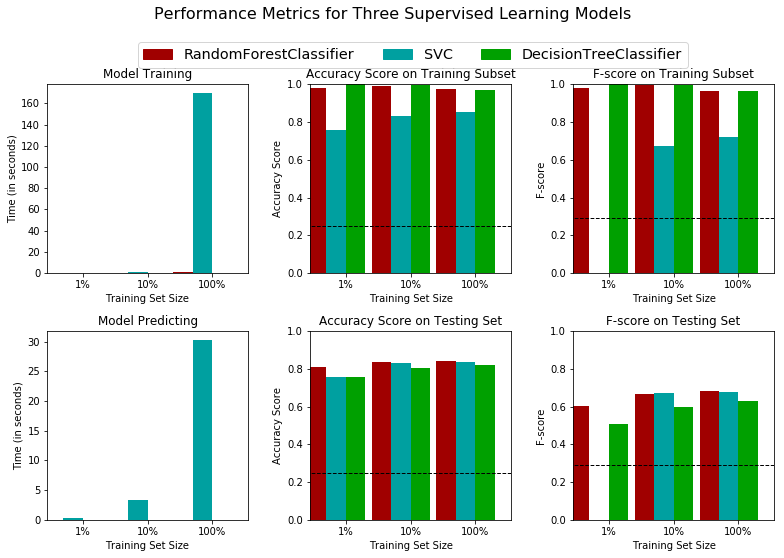

In [11]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


# TODO: Initialize the three models
clf_A = RandomForestClassifier(random_state=42)
clf_B = SVC(random_state=42)
clf_C = DecisionTreeClassifier(random_state=42)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int((10 * samples_100)/100)
samples_1 = int((1 * samples_100)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

**HINT:** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer:**
Based on the evaluation that we have performed earlier , we will believe in 'Random Forest Classifier' to be most appropriate for the task of identifying individuals that make more than $50000 . Reason being , we are coming to these conclusions after analysing the above graphs .

Before choosing random forest classifier as the best one . Lets identify how we concluded what we concludes . So to start with we did not start with picking the best one up but rather eliminating the worst cases first .

So lets start with taking into consideration the training time for the testing set, we can conclude that SVC is taking the highest training time of approx 29 seconds . while RFC for 0.23 seconds(approx) and decision tree classifiers are consuming much less . 

So if we analyse and observe the time predictions on the testing set we can clearly discard SVC for our case as it is taking much more time compared to RandomForestClassifier and Decision Trees . 

We can see that when we use 100% of the testing set to make the prediction. The fscore of Random Forest Classifier is approximately 0.628 which is much likely to be same for SVC as well but it is nearly 61% for decision tree classifier . As per Fscore both random forest and support vector machines are doing good . Decision Tree is also performing slightly lower than SVC .

Thus keeping Fscore and Prediction time in mind , we prefer to go for Random Forest Classifer because it has higher FScore and also take less time to execute . So it is win-win situation for us both from the perspective of time consumed and also Fscore . 

Also another reason for choosing random forest classifier over decision trees is it seems to overfit . Like we have 0.97 Fscore approx on training set but it has only 0.62 Fscore approx on testing which is lowest of all the 3 cases Fscore . 

If we also consider algorithms suitability for the data , we can say that Random Forest Deals with both categorial and numerical data , hence we can use random forest classifier for our case .

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer:**

Random Forest Classifier 
We have created multiple decision trees of the data available . In each of these decision trees we will take different combination of columns . These columns can be picked based on our choices . Please note that for all the cases we need not take all the columns into considerations . We can skip some columns in some case and pick those in other cases . Also it is okay if we pick the same column multiple times in different decision trees but with a different combination . So we will form some unique decision trees based on what is available in the dataset . 
Now we will train our model . 
Each datapoint that we train will undergo the examination by all the decision trees , we will at last pick the outcome or the prediction which has occured in outcome of maximum number of decision trees . 


Let us follow this by using a simple example . Suppose I want to go to Dominos to eat a Pizza . I am going to Dominos for the first time . My friends want my experience to be the best ones in terms of choosing pizza I love the most . There are several options at the shop we are going for party . It includes - Pizza Veg Extravaganza , Pizza Margherita , Cheese Burst Pizza , Burger Pizza , Non Veg Pizza , Tomatoes Pizza, Onion Pizza, Golden Corn Pizza etc. 

Each of these person now start brainstorming to get me pick the best one . So one of them is trying to figure out whether I would choose Veg or Non Veg . Someone tries to find out if I like vegetables and if yes what all vegetables and do I prefer tomato more or onion more . Someone tries to figure out if I like cheese or paneer and do I like Gold corn . With these kinds of different questions in mind they come to somewhat different and somewhat same conclusions in the end we unite their conclusions by voting for it and hence come up with some final conclusion . So each of these friends are picking up some selective features of their choice and by asking different questions they are forming their own decision trees .  
**References**
http://blog.echen.me/2011/03/14/laymans-introduction-to-random-forests/




### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [12]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
# TODO: Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
# parameters = {'n_estimators':[10, 100, 500, 700]}
parameters = {'min_samples_leaf':[2, 5, 7, 10]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8431
F-score on testing data: 0.6842

Optimized Model
------
Final accuracy score on the testing data: 0.8582
Final F-score on the testing data: 0.7263


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |   0.8431          |     0.8582      |
| F-score        |   0.6842          |     0.7263      |


**Answer: **

* The optimised models accuracy on testing set is 0.8582 and the optimised model's F-score on testing data is 0.7263 . 

* These scores of optimised are better both in terms of accuracy as well as Fscore when compared to unoptimised model . 

* Our optimised model scores are much higher compared to the benchmarks found in Naive Predictor . The benchmarks identified in Naive Predictor for Accuracy Score is 0.2748 and our optimised model accuracy is 0.8542 . The benchmarks identified in Naive Predictor for Fscore is 0.2917 and our optimised model Fscore is 0.7263 . Thus we can observe remarkable growth in both Accuracy Score and Fscore . 


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**
Of all the thirteen features that are available to us for each individual in this dataset, the five factors I believe to be most important for prediction are : 
1. Workclass 
2. Education 
3. Occupation
4. Race
5. Hours Per Week .

The order of ranking for these best 5 features would be (The features with top most priority are at the top): 
**1. Education-** I would give the highest preference to the education of the person because the more educated the person is the more likely it is for the person to have access to better opportunities and generate higher income . So this is obvious that the person who have completed higher education may opt for executive level positions etc and may get more money . 

**2. Workclass** I would give next priority to working class because I feel that most countries pay more to people who are associated with Gov work class earn more than private workclass employee in a very generic scenario . Also we have placed education prior to workclass because choosing workclass is one thing but getting selected and hired in the one of your choice can involve a process of  competitive examinations where employees can be judged based on their knowledge . It is very likely that person who has more knowledge may likely to get selected . So education is the primary factor . Rather in what category a person will fall is influenced by education . 

**3. Occupation** First of all I would throw a point to explain that yes occupation would affect the annual salary of a person . Like suppose a occupation which has more demand and less supply is likely to generate more income for the employee rather than a occupation which has less demand and more supply . Also there are occupation which involve less education and less knowledge but more of physical work but does not generate good revenues . On the other hand their are occupations which involve more skilled work and less physical work but generate more income . 
Also we are priortized occupation after education is because education is influencing where a person will be in more or less skilled occupation . However the reason of rating workclass prior to occupation is the difference between Govt and Private Employees would create a greater difference in the salaries compared to the salaries of people in less skilled and more skilled profession .  

**4. Hours per week** Yes this would affect the income because a person working for less number of hours would earn less and a person working for more number of hours would earn more . I would keep education and occupation prior to hours per week because education is the ticket to the person to get hired for more number of hours or less . Also if the person is into skilled profession and gets hired for less time but as the job is in demand he can end up earning more . But there will be less likely the cases on a generic basis where we have people who are hired on hourly basis and there will be more full month paid basis employees. ALso there will be more full time working people and less part time jobs .  

**5. Race** - I would give Race Preference above all the factors we left below because the data is of 1994 US census so there are more chances of biased decisions on the basis of Black Race and white race . We have seen that the income and opportunities in the industries in 30% cases were influenced by biased decisions . We can so firmly say that it was influenced because it is now in the last few years that we have started to hear about campaigns for equal rights and equal opportunites . So we have started to combat the change of equal opportunities but it is not completely into practice . Some organisations have though adopted . But as in 1994 that was truely an influencing factor . Also still I would believe education, workclass, occupation would be prior to this . Because biased decisions can only influence judgement in some cases but not when a White Less Education (4th class) comes to stand a competition with a high grad black . The huge mismatch of skillset at higher package won't let the less educated on an opportunity . 




### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

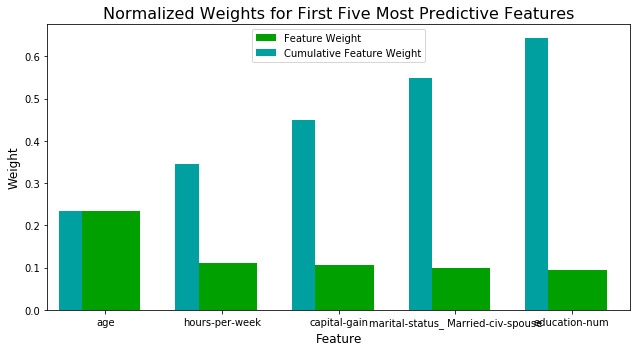

In [13]:
# TODO: Import a supervised learning model that has 'feature_importances_'


# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier(random_state=42).fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**
* These five features are very different compared to the ones I discussed in Question 6 . The features discussed in question 6 are workclass, education, occupation, race, hours per week . The features obtained after feature_importances_ are age, hour per week, capital gain, marital status , education number . Though hours per week was one of it where I was close by . 

* I was not close to it . I think the above features(age, hours per week, capital gain, marital-status, education-number) would be more relevant . 
--> Age - I would feel age would matter because a person who is working for more number of years and holds more experience in the profession has more better skills and hence would end up earning more . So senior people into professions are paid more than junior people or fresher . 

--> Hours per week: this was one of the factors we have also taken into consideration in question 6. So I feel this is okay . Because People working for part time will be paid less and full time will be paid more . But if we compare of Age we feel that the difference in the income of senior people and junior people will be more compared to hours per week . 

--> Capital Gain - I feel that capital gain had a fundamental of the story from "Rich Dad Poor Dad" so there are people who get paid for working for the number of hours but there are some people who get paid even when they sleep . This could happen because they have planned their investments into assets nicely hence we feel that they would earn money when the rate of the assests are high when they sell . That is the price is high . So that would be a role with stock market . 

--> Marital Status - well I am not very much sure on marital status of the person . But may be people who are divorced are given more priority in getting exposed to better opportunities and they get reservation in good positions and hence end up making more . 

--> Education Number - I actually misunderstood the concept of education number, I related to number of years the person has devoted in education but this factor also holds a significant relationship with education so we can see that people who have done masters are scoring around 14 and who have done bachelors are scoring 13 High School Graduate is 9 and 11th is 7 . So I can now connect to the fact it holds a relationship with education and hence it makes more sense than education because it is a discrete integer number spread on a range of 0, 1 , 2 , 3 and so on a scale range and hence becomes more decisive a factor to contribute to how much income a person makes rather than education itself because integer are more decisive . 

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [14]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8582
F-score on testing data: 0.7263

Final Model trained on reduced data
------
Accuracy on testing data: 0.8491
F-score on testing data: 0.7012


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:** 
* We can see that when we use all the features the final models accuracy on the testing data is 0.8582 and the final model's Fscore on testing data is 0.7263  and when we use reduced data the final models accuracy on testing data is 0.8491 and Fscore is 0.7012 . So I would say there is a slight drop in the accuracy score and Fscore when using with reduced data . 

* Yes if training time would have been a factor, I would have considered using on reduced data as your training set because we can see that the difference in accuracy score and fscore is not too large, it is just the slight drop which we can manage keeping computational cost and time also as important parameters in mind . 




> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

##Before You Submit
You will also need run the following in order to convert the Jupyter notebook into HTML, so that your submission will include both files.

In [15]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook finding_donors.ipynb to html',
 '[NbConvertApp] Writing 499361 bytes to finding_donors.html']